# 사전 학습된 ConvNet을 이용한 전이 학습

- 사전 훈련된 모델은 이전에 대규모 데이터셋에서 훈련된 저장된 네트워크로, 일반적으로 대규모 이미지 분류 작업에서 훈련된 것입니다. 사전 훈련된 모델을 그대로 사용하거나 전이 학습을 사용하여 이 모델을 주어진 작업으로 사용자 정의하세요.
- 이미지 분류를 위한 전이 학습을 직관적인 시각에서 바라보면 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 시각 세계의 일반적인 모델로서 기능할 것이라는 점입니다. 그런 다음 대규모 데이터셋에서 대규모 모델을 교육하여 처음부터 시작할 필요 없이 이러한 학습된 특징 맵을 활용할 수 있습니다.
---
- __특성 추출__: 새 샘플에서 의미 있는 특성을 추출하기 위해 이전 네트워크에서 학습한 표현을 사용합니다. 사전 훈련된 모델 위에 처음부터 훈련할 새 분류자를 추가하기만 하면 이전에 데이터세트로 학습한 특성 맵의 용도를 재사용할 수 있습니다.
- __미세 조정__: 고정된 기본 모델의 일부 최상위 층을 고정 해제하고 새로 추가 된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시킵니다. 이를 통해 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 보다 관련성이 있도록 할 수 있습니다.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import logging

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [19]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip',
                                      origin=_URL,
                                      extract=True)

68606236/68606236 [==============================] - 2s 0us/step


In [5]:
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [6]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


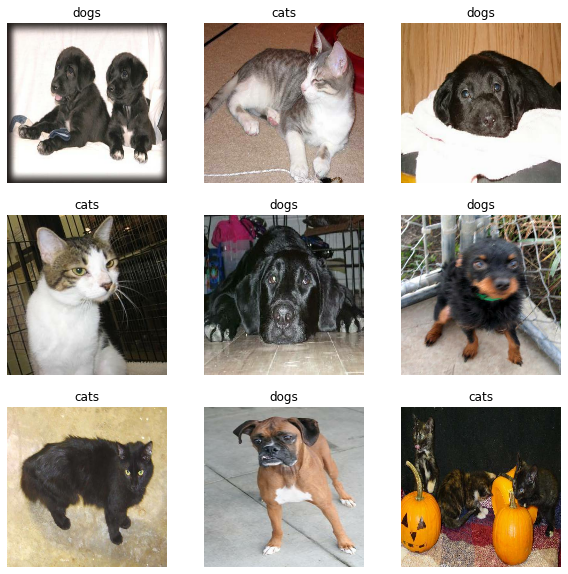

In [9]:
# 훈련용 데이터셋에서 처음 두 개의 이미지 및 레이블을 보여줍니다:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# 원본 데이터세트에는 테스트 세트가 포함되어 있지 않으므로 테스트 세트를 생성합니다.
# tf.data.experimental.cardinality를 사용하여
# 검증 세트에서 사용할 수 있는 데이터 배치 수를 확인한 다음
# 그 중 20%를 테스트 세트로 이동합니다.
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [14]:
print('Number of validation batches: %d' %
      tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' %
      tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# 버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 이미지를 로드합니다.
# AUTOTUNE = -1
# buffer_size=-1인 경우 동적으로 buffer size 지정
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

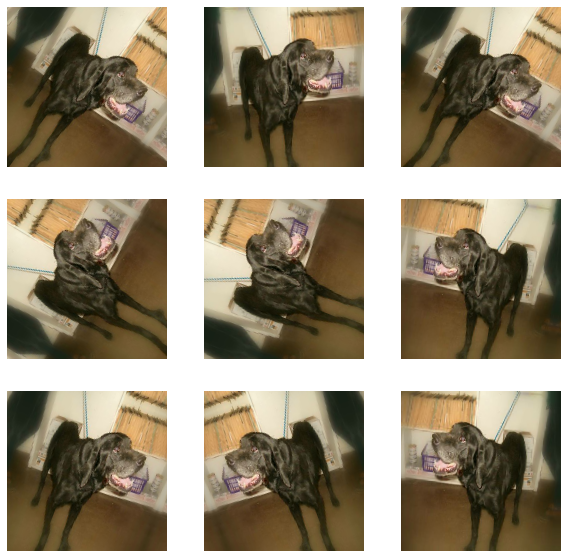

In [20]:
# 큰 이미지 데이터세트가 없는 경우,
# 회전 및 수평 뒤집기와 같이 훈련 이미지에 무작위이지만 사실적인 변환을 적용하여
# 샘플 다양성을 인위적으로 도입하는 것이 좋습니다.
# 이것은 모델을 훈련 데이터의 다양한 측면에 노출시키고 \
# 과대적합을 줄이는 데 도움이 됩니다.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [21]:
# 픽셀 값 재조정
# 기본 모델로 사용할 tf.keras.applications.MobileNetV2 모델은 [-1, 1]로 학습
# [0, 255]에서 [-1, 1]로 픽셀 값을 재조정
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5,
                                                               offset=-1)

- Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성
- 이 모델은 1.4M 이미지와 1000개의 클래스로 구성된 
- 대규모 데이터셋인 ImageNet 데이터셋를 사용해 사전 훈련된 모델
---
- 특성 추출에 사용할 MobileNet V2 레이어를 선택해야 합니다.
---
- flatten 연산을 하기 전에 맨 마지막 레이어를 가지고 진행
- 이 레이어를 "병목 레이어"라고 합니다. 
- 병목 레이어 특성은 마지막/맨 위 레이어보다 일반성을 유지합니다.
---
- **include_top = False** 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적

In [22]:
IMG_SHAPE = IMG_SIZE + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [23]:
# 이 특징 추출기는 각 160x160x3 이미지를 5x5x1280개의 특징 블록으로 변환
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# 특징 추출

- 이 단계에서는 이전 단계에서 작성된 컨벌루션 베이스 모델을 동결하고 특징 추출기로 사용합니다. 또한 그 위에 분류기를 추가하고 최상위 분류기를 훈련시킵니다.

## 컨볼루션 베이스 모델 고정하기

- 모델을 컴파일하고 훈련하기 전에 컨볼루션 기반을 고정하는 것이 중요합니다. 동결(layer.trainable = False로 설정)은 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지합니다. MobileNetV2에는 많은 레이어가 있으므로 전체 모델의 trainable 플래그를 False로 설정하면 레이어가 모두 동결됩니다.

## BatchNormalization 레이어에 대한 중요 참고 사항
- 많은 모델에는 tf.keras.layers.BatchNormalization 레이어가 포함되어 있습니다. 이 레이어는 특별한 경우이며 이 튜토리얼의 뒷부분에 나와 있는 것처럼 미세 조정의 맥락에서 주의를 기울여야 합니다.

- layer.trainable = False를 설정하면 BatchNormalization 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.

- 미세 조정을 위해 BatchNormalization 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 training = False를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 파괴됩니다.

In [26]:
base_model.trainable = False

In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [28]:
# 분류 층을 맨 위에 추가하기
# 특성 블록에서 예측을 생성하기 위해
# tf.keras.layers.GlobalAveragePooling2D 레이어를 사용하여
# 특성을 이미지당 하나의 1280-요소 벡터로 변환하여
# 5x5 공간 위치에 대한 평균을 구합니다.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [29]:
# tf.keras.layers.Dense 레이어를 사용하여
# 특성을 이미지당 단일 예측으로 변환합니다.
# 이 예측은 logit또는 원시 예측 값으로 취급되므로
# 활성화 함수가 필요하지 않습니다.
# 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [30]:
# Keras Functional API를 사용하여
# 데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 함께 연결하여
# 모델을 구축합니다.
# 앞서 언급했듯이 모델에 BatchNormalization 레이어가 포함되어 있으므로
# training=False를 사용하세요.
inputs = tf.keras.Input(shape=(160, 160, 3))

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [31]:
# 모델 컴파일
# 학습하기 전에 모델을 컴파일해야 합니다.
# 두 개의 클래스가 있으므로 모델이 선형 출력을 제공하므로
# from_logits = True와 함께 이진 교차 엔트로피 손실을 사용하세요.
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\HP\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [33]:
# MobileNet의 2.5M 개의 매개 변수는 고정되어 있지만
# Dense 층에는 1.2K 개의 trainable 매개 변수가 있습니다.
# 이것들은 두 개의 tf.Variable 객체, 즉 가중치와 바이어스로 나뉩니다.
len(model.trainable_variables)

2

In [34]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 6s 168ms/step - loss: 0.8194 - accuracy: 0.4975


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.82
initial accuracy: 0.50


In [36]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 18s 254ms/step - loss: 0.6899 - accuracy: 0.5945 - val_loss: 0.5221 - val_accuracy: 0.6287
Epoch 2/10
63/63 [==============================] - 16s 256ms/step - loss: 0.5222 - accuracy: 0.6990 - val_loss: 0.3691 - val_accuracy: 0.8007
Epoch 3/10
63/63 [==============================] - 16s 252ms/step - loss: 0.3959 - accuracy: 0.8060 - val_loss: 0.2758 - val_accuracy: 0.8762
Epoch 4/10
63/63 [==============================] - 16s 251ms/step - loss: 0.3299 - accuracy: 0.8430 - val_loss: 0.2199 - val_accuracy: 0.9084
Epoch 5/10
63/63 [==============================] - 18s 282ms/step - loss: 0.2867 - accuracy: 0.8725 - val_loss: 0.1875 - val_accuracy: 0.9332
Epoch 6/10
63/63 [==============================] - 18s 280ms/step - loss: 0.2571 - accuracy: 0.8840 - val_loss: 0.1611 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 17s 277ms/step - loss: 0.2281 - accuracy: 0.9035 - val_loss: 0.1399 - val_accuracy: 0.9592

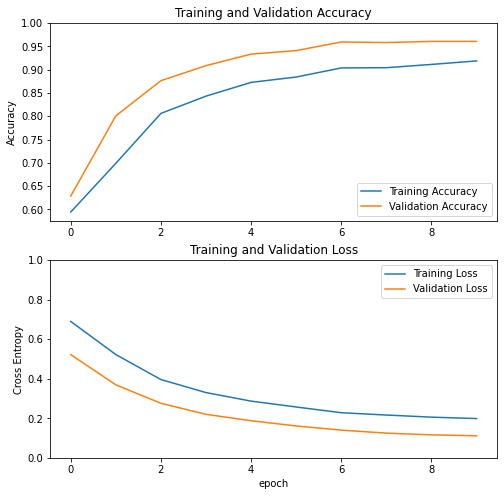

In [37]:
# 학습 곡선
# MobileNet V2 기본 모델을 고정된 특징 추출기로 사용했을 때의
# 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 미세 조정

- 특징 추출에서는 MobileNet V2 기본 모델을 기반으로만 학습했습니다. 사전 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 않았습니다.
---
- 성능을 더욱 향상시키는 한 가지 방법은 추가 한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련(또는 "미세 조정")하는 것입니다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정됩니다.
---
- 또한 전체 MobileNet 모델이 아닌 소수의 최상위 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서 층이 높을수록 층이 더 전문화됩니다. 처음 몇 층은 거의 모든 유형의 이미지로 일반화되는 매우 간단하고 일반적인 특징을 학습합니다. 더 높은 수준으로 올라가면 훈련에 사용된 데이터 세트에 맞춰 특징이 점점 더 구체화 됩니다. 미세 조정의 목표는 이러한 전문화된 특징이 일반적인 학습을 덮어쓰지 않고 새 데이터셋에 맞춰 잘 동작 수 있도록 조정하는 것입니다.

In [38]:
# 최상위 층 고정 해제하기
# base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다.
# 그런 다음 모델을 다시 컴파일하고 훈련을 다시 시작해야 합니다.
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [40]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate /
                                                    10),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [42]:
len(model.trainable_variables)

56

In [43]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 26s 354ms/step - loss: 0.1510 - accuracy: 0.9355 - val_loss: 0.0599 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 21s 336ms/step - loss: 0.1178 - accuracy: 0.9505 - val_loss: 0.0520 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 21s 339ms/step - loss: 0.1155 - accuracy: 0.9575 - val_loss: 0.0466 - val_accuracy: 0.9790
Epoch 13/20
63/63 [==============================] - 26s 409ms/step - loss: 0.0844 - accuracy: 0.9680 - val_loss: 0.0387 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 26s 405ms/step - loss: 0.0913 - accuracy: 0.9650 - val_loss: 0.0391 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 25s 396ms/step - loss: 0.0913 - accuracy: 0.9590 - val_loss: 0.0396 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 25s 394ms/step - loss: 0.0775 - accuracy: 0.9695 - val_loss: 0.0420 - val_accuracy:

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

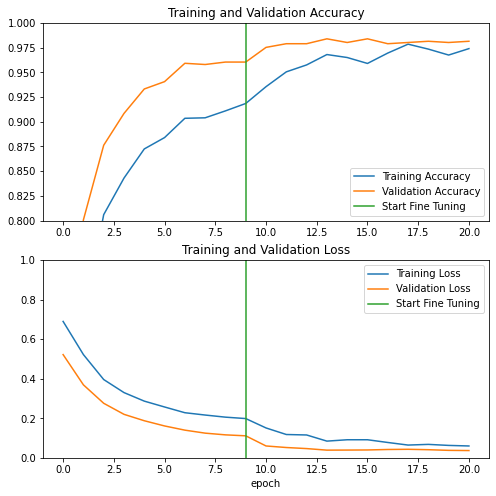

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(),
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(),
         label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 170ms/step - loss: 0.0130 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


Predictions:
 [0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0]
Labels:
 [0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0]


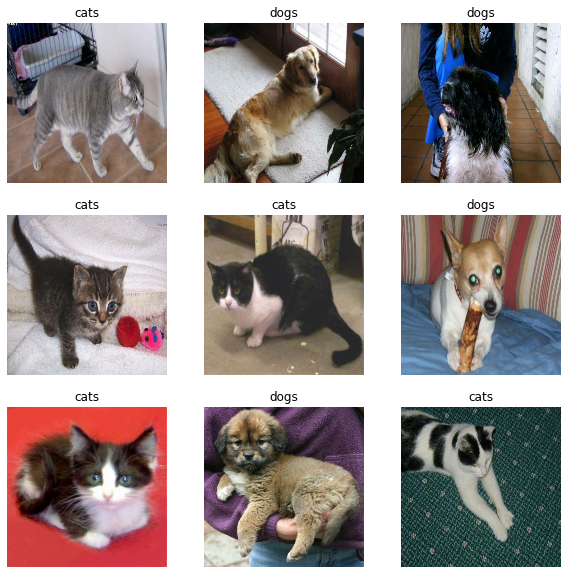

In [47]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# 요약:

- __특징 추출을 위해 사전 훈련된 모델 사용하기:__ 작은 데이터셋으로 작업 할 때는 동일한 범주의 클래스의 더 큰 데이터셋으로 훈련시킨 사전 학습된 모델의 특징을 활용하는 것이 일반적입니다. 사전 훈련된 모델을 인스턴스화하고 완전히 연결된 분류기를 맨 위에 추가하면 됩니다. 사전 훈련된 모델은 "고정"되고 분류기의 가중치만 훈련 중에 업데이트됩니다. 이 경우 컨벌루션 베이스 모델은 각 이미지와 관련된 모든 특징을 추출하며 주어진 추출된 특징을 가지고 이미지 클래스를 결정하는 분류기를 훈련합니다.
- __사전 훈련된 모델을 미세 조정하기:__ 성능을 더욱 향상시키기 위해 사전 훈련된 모델의 최상위 계층을 미세 조정을 통해 새 데이터셋으로써 재사용 할 수 있습니다. 이 경우 모델이 주어진 데이터셋에 맞는 상위 레벨의 특징을 학습 할 수 있도록 가중치를 조정합니다. 이 기술은 일반적으로 훈련 데이터셋의 규모가 크고, 사전 훈련된 모델이 사용했던 원래 데이터셋과 매우 유사한 경우에 권장됩니다.